In [2]:
import json
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)

In [95]:
with open('data/topicalchat_midas_cobot_entities.json', 'r') as f:
    data = json.load(f)

In [3]:
with open('data/topicalchat_midas_cobot_entities_.json', 'r') as f:
    data_ = json.load(f)

In [6]:
len(data), len(data_)

(8628, 8628)

In [4]:
def split_utterance(ut: dict) -> tuple:
    """ 
    if an utterance contains more than one sentence,
    split it and align with MIDAS labels
    """
    try:
        sents = sent_tokenize(ut['text'])
    except:
        sents = [ut['text']]
    
    if len(sents) != len(ut['midas_label']):
        # for now, skip this category as it is not clear why they do not correspond
        return list(), list()
    
    midas_labels = [max(labels, key=labels.get) for labels in ut['midas_label']]
    
    one_entity = list()
    zero_entity = list()
    
    for sent, midas_label in zip(sents, midas_labels):
        counter = 0
        sentence_ents = []
        
        if 'message' not in ut['ner']:
            for ent in ut['ner']['response']:
                if ent['text'] in sent:
                    sentence_ents.append(ent)
                    counter = len(sentence_ents)
                
        if counter > 1:
        # skip if an utterance has more than 1 entity
            continue
        
        if counter == 0:
            # if there are no entities, use only midas labels
            zero_entity.append({
                'text': sent,
                'midas_label': midas_label})
            continue

        one_entity.append({
            'text': sent.replace(sentence_ents[0]['text'], sentence_ents[0]['label'].upper()),
            'midas_label': midas_label,
            'entity': sentence_ents[0]})
        
    return one_entity, zero_entity

In [5]:
one_entity_df = []
zero_entity_df = []

for idx in list(data_.keys()):
    for ut in data_[idx]:
        if 'message' in ut['ner'] or len(ut['ner']['response']) == 0:
            # skip utterences that have no entities
            _, zero_entity = split_utterance(ut)
            zero_entity_df.extend(zero_entity)
            continue
        
        if len(ut['midas_label']) == 1 and len(ut['ner']['response']) == 1:
            # take those that have one sentence and one entity
            one_entity_df.append(
                {'text': ut['text'].replace(ut['ner']['response'][0]['text'], ut['ner']['response'][0]['label'].upper()),
                'midas_label': max(ut['midas_label'][0], key=ut['midas_label'][0].get),
                'entity': ut['ner']['response'][0]})
            continue

        if len(ut['midas_label']) > 1:
            one_entity, zero_entity = split_utterance(ut)
            zero_entity_df.extend(zero_entity)
            one_entity_df.extend(one_entity)
            
one_entity_df = pd.json_normalize(one_entity_df)
zero_entity_df = pd.json_normalize(zero_entity_df)

In [11]:
one_entity_df.head()

,text,midas_label,entity.text,entity.label
0,Both are excellent MISC they are helpful in many ways.,opinion,technology,misc
1,I think ANAPHOR are a monopoly in some sense.,opinion,they,anaphor
2,"Yeah, ANAPHOR services are good.",comment,their,anaphor
3,"By the way, do you like MISC?",yes_no_question,Fish,misc
4,MISC is the biggest part in the eco-system.,statement,Fish,misc


In [12]:
one_freq = one_entity_df.value_counts(["midas_label", "entity.label"]).reset_index()
one_freq['category'] = one_freq["midas_label"] + "+" + one_freq["entity.label"]
one_freq = one_freq.iloc[:, [3,2,0,1]].rename(columns = {0: "counter"})

In [13]:
one_freq.head()

,category,counter,midas_label,entity.label
0,opinion+misc,16130,opinion,misc
1,opinion+anaphor,11576,opinion,anaphor
2,statement+misc,9633,statement,misc
3,statement+anaphor,5972,statement,anaphor
4,yes_no_question+misc,5480,yes_no_question,misc


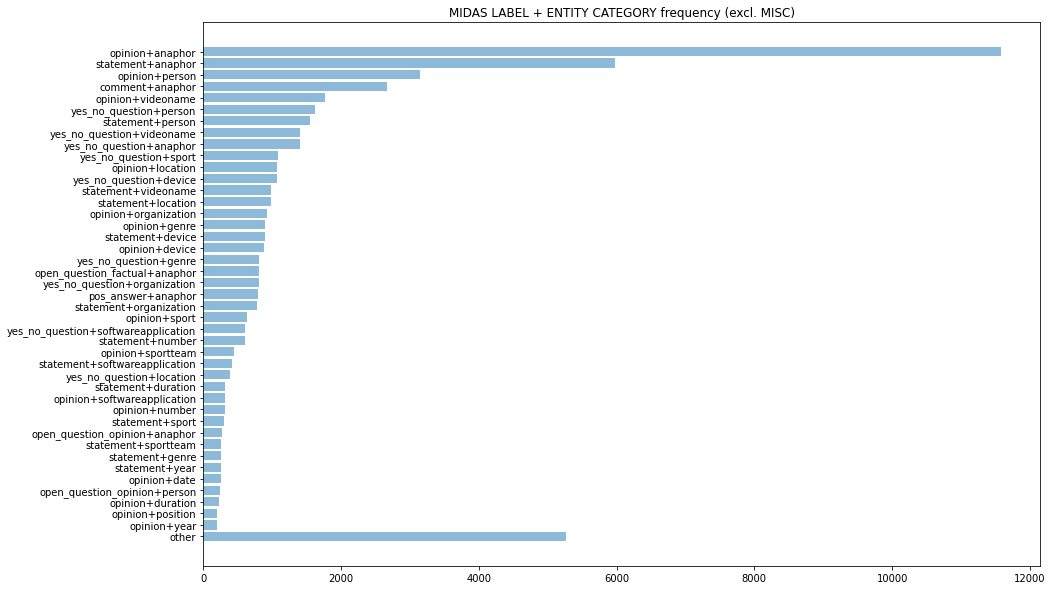

In [14]:
#defining the threshold 
df = one_freq[one_freq['entity.label'] != 'misc'].iloc[:, [0,1]]
threshold = 200
mask = df['counter'] < threshold
df1 = df[~mask].copy()
df1.loc[df.shape[0]+1] = df.loc[mask, 'counter'].sum()

labels = df1.category.tolist()
labels[-1] = 'other'
y_pos = np.arange(len(labels))
counter = df1.counter.tolist()

plt.figure(figsize=(15,10))
plt.barh(y_pos, counter, align='center', alpha=0.5)
plt.yticks(y_pos, labels)
plt.gca().invert_yaxis()
plt.title('MIDAS LABEL + ENTITY CATEGORY frequency (excl. MISC)')
plt.savefig("img/groupings.png")

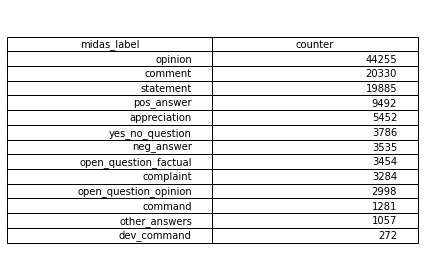

In [15]:
zero_freq = zero_entity_df.value_counts(["midas_label"]).reset_index().rename(columns = {0: "counter"})
fig, ax = plt.subplots()
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=zero_freq.values, colLabels=zero_freq.columns, loc='center')
fig.tight_layout()
plt.savefig("img/zero_ent_by_midas.png")

In [16]:
zero_entity_df[zero_entity_df.midas_label == 'yes_no_question']

,text,midas_label
172,DId you know that?,yes_no_question
177,Do you have any now?,yes_no_question
208,Do you?,yes_no_question
323,Do they really?,yes_no_question
358,Do you know what the 'candy desk' tradition is about?,yes_no_question
...,...,...
118838,Do you play?,yes_no_question
118858,You?,yes_no_question
118993,Yeah isn't that just crazy how many there are?,yes_no_question
119058,Do you enjoy any in particular?,yes_no_question


In [17]:
result = one_entity_df.to_json(orient="records")
parsed = json.loads(result)  

one_entitiy_dataset = {}

for sample in parsed:
    category = sample['midas_label'] + "__" + sample['entity.label']
    
    if category not in one_entitiy_dataset:
        one_entitiy_dataset[category] = [sample['text'].strip()]
    else:
        one_entitiy_dataset[category].append(sample['text'].strip())
        
with open('data/one_entity.json', 'w', encoding='utf-8') as f:
    json.dump(one_entitiy_dataset, f, ensure_ascii=False, indent=4)

In [18]:
result = zero_entity_df.to_json(orient="records")
parsed = json.loads(result)

zero_entitiy_dataset = {}

for sample in parsed:
    if sample['midas_label'] not in zero_entitiy_dataset:
        zero_entitiy_dataset[sample['midas_label']] = [sample['text'].strip()]
    else:
        zero_entitiy_dataset[sample['midas_label']].append(sample['text'].strip())
        
with open('data/zero_entity.json', 'w', encoding='utf-8') as f:
    json.dump(zero_entitiy_dataset, f, ensure_ascii=False, indent=4)

In [91]:
result = {}
for i, sample in enumerate(mismatch):
    result[i] = {}
    result[i]['text'] = sample[0]
    result[i]['sents'] = sample[1]
    result[i]['midas'] = sample[2]

with open('data/mismatch.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [92]:
result = {}
for i, sample in enumerate(aligned):
    result[i] = {}
    result[i]['text'] = sample[0]
    result[i]['sents'] = sample[1]
    result[i]['midas'] = sample[2]

with open('data/aligned.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)